lipid bilayer, air-water system

In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
# import scipy
from refnx.version import version
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective, Model, Parameter
from refnx.reflect import SLD, Slab, ReflectModel, LipidLeaflet
# from sepObjectiveGO import getObjective as gO
from dynesty import DynamicNestedSampler
from dynesty import plotting as dyplot
from CFitter import CFitter
import make_sim_data as msd
print('refnx: %s\nnumpy: %s' % (version,
                    np.version.version))
%matplotlib inline

refnx: 0.1.9
numpy: 1.16.4


In [2]:
def aPlotter(res, interestingNo, spacesize, figI):
    print(figI)
    # no = -1000
    # slc = slice(no-1000,no)
    useAbleLow=0.1
    useAbleHigh=10.
    xall=np.linspace(0,spacesize,len(res["logz"]))
    print("len",len(res["logz"]), "space size", spacesize)
    useable=np.transpose(np.array([[x,y] for y,x in zip(res["logz"],xall) if np.exp(y)>useAbleLow and np.exp(y)<=useAbleHigh]))
    # print(len(res["logz"]),res["logz"][slc])#summary()
    interesting = np.transpose(np.array([[x,y] for y,x in zip(res["logz"],xall) if x>=float(interestingNo)]))#.reshape((2,-2))
#     print("len 2", len(interesting[0]), len(interesting), interesting[0,:3])
    print("logz max: ",max(res["logz"]),",min: ",min(res["logz"]))
    print("z max: ",max(np.exp(res["logz"])),",min: ",min(np.exp(res["logz"])))
#     print(res["logz"][:5],interesting[1,:5],useable[1,:5])
    # print("interesting")
#     xall=np.linspace(0,spacesize,len(res["logz"]))
#     xusable=np.linspace(0,spacesize,len(useable))
    plt.figure(figI)
    figI+=1
    if len(useable)>=2:
        n_plots = 3
    else:
        n_plots = 2
    plt.subplot(1, n_plots, 1)
    plt.plot(xall,res["logz"])
    if any([lnz<=0 for lnz in res["logz"]]):
        plt.title("ln(evidence)\n not log scaled vs -ln(X)")
        plt.plot(xall, [0 for value in xall], label="ln(evidence)=0", alpha=0.4,linestyle="--")
    else:
        plt.title("ln(evidence)\n log scaled vs -ln(X)")
        plt.yscale("log")
    plt.xlabel("-ln(X)")
    plt.ylabel("ln(evidence)")
#     plt.figure(figI)
#     figI+=1
    plt.subplot(1, n_plots, 2)
    plt.plot(interesting[0],interesting[1])
    plt.title("interesting values\n ln(evidence)\n"+r" vs -ln(X) $\geq %d$" % interestingNo)
    plt.xlabel("-ln(X)")
    plt.ylabel("ln(evidence)")
    if len(useable)>=2:
        plt.subplot(1, n_plots, 3)
        plt.plot(useable[0],useable[1])
        plt.title("usful values\n"+r"ln(%.3f<evidence $\leq$ %.3f) vs -ln(X)"%(useAbleLow,useAbleHigh))
        plt.xlabel("-ln(X)")
        plt.ylabel("ln(evidence)")
    else:
        print("not enough 'usable' data points")
    print(figI)
    plt.tight_layout()
    return figI

def min_interesting_lnX(res):
    returns = None
    for lnX, logz in zip(res["logvol"], res['logz']):
        if logz >= 0.:
            break
        else:
            returns = -lnX
#     returns = min([-lnX for lnX, wt in zip(res["logvol"], np.exp(res['logwt'] - res['logz'][-1])) if wt>0])
    return returns

maxLength = 80
def logp_extra(model, data=None):
    returns = 0
    if sum(model.structure.slabs()[1:-1,0])>maxLength:
        returns = -np.inf
    return returns

In [3]:
#making layers

# SLDs
def makeTrue():
    air = SLD(0 + 0j)
    d2o = SLD(6.36 + 0j)
    h2o = SLD(-0.56 + 0j)
    hdmix = SLD(2.07 + 0j)
    
    d2o.real.setp(vary=True, bounds=(6.1, 6.36))
    d2o.real.name='d2o SLD'

    apm = Parameter(56, 'area per molecule', vary=True, bounds=(52, 65))
    b_heads = Parameter(6.01e-4, 'b_heads')
    b_tails = Parameter(-2.92e-4, 'b_tails')
    v_heads = Parameter(319, 'v_heads')
    v_tails = Parameter(782, 'v_tails')
    inner_head_thickness = Parameter(9, 'inner_head_thickness', vary=True, bounds=(4, 11))
    outer_head_thickness = Parameter(9, 'outer_head_thickness', vary=True, bounds=(4, 11))
    tail_thickness = Parameter(14, 'tail_thickness', vary=True, bounds=(10, 17))

    inner_leaflet = LipidLeaflet(apm,
                                 b_heads, v_heads, inner_head_thickness,
                                 b_tails, v_tails, tail_thickness,
                                 3, 3)
    outer_leaflet = LipidLeaflet(apm,
                                 b_heads, v_heads, outer_head_thickness,
                                 b_tails, v_tails, tail_thickness,
                                 3, 0, reverse_monolayer=True)

    solv_roughness = Parameter(3, 'bilayer/solvent roughness')
    solv_roughness.setp(vary=True, bounds=(0, 5))
    
    s_d2o = air | inner_leaflet | outer_leaflet | d2o(0, solv_roughness)
    s_hdmix = air | inner_leaflet | outer_leaflet | hdmix(0, solv_roughness)
    s_h2o = air | inner_leaflet | outer_leaflet | h2o(0, solv_roughness)
    return s_d2o,s_hdmix,s_h2o
# model_h2o.bkg.setp(vary=True, bounds=(-1e-6, 1e-6))
# objective_h2o = Objective(model_h2o, data_h2o)
true_s_d2o,true_s_hdmix,true_s_h2o = makeTrue()


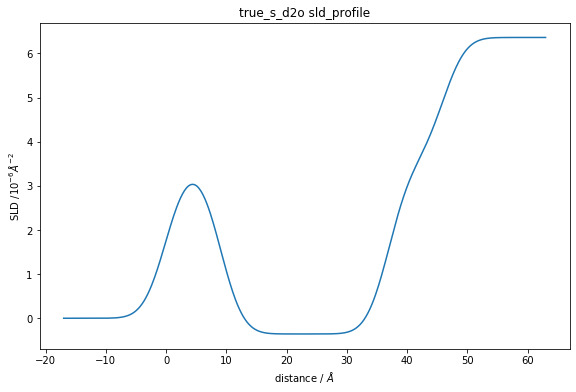

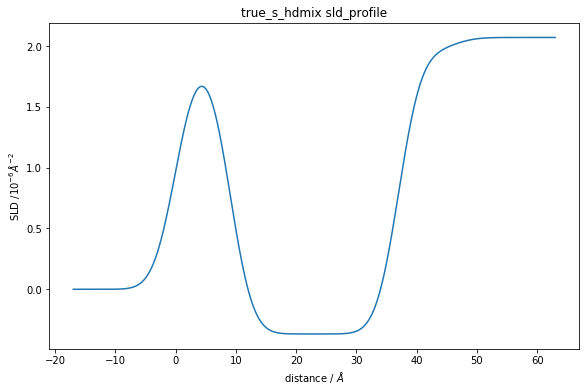

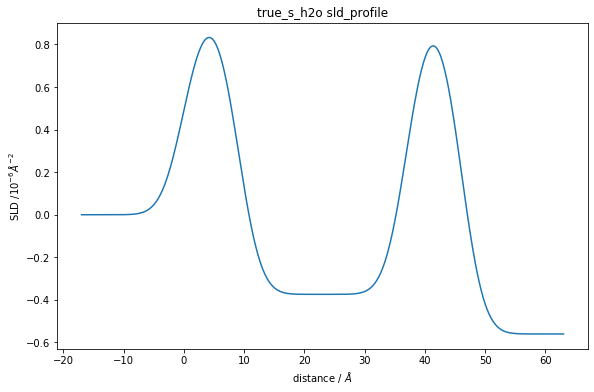

In [4]:
figI=0
plt.rcParams['figure.figsize'] = [9.5, 6]
plt.figure(figI)
figI+=1
plt.plot(*true_s_d2o.sld_profile())
plt.title("true_s_d2o sld_profile")
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');

plt.rcParams['figure.figsize'] = [9.5, 6]
plt.figure(figI)
figI+=1
plt.plot(*true_s_hdmix.sld_profile())
plt.title("true_s_hdmix sld_profile")
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');

plt.rcParams['figure.figsize'] = [9.5, 6]
plt.figure(figI)
figI+=1
plt.plot(*true_s_h2o.sld_profile())
plt.title("true_s_h2o sld_profile")
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');

In [5]:
resolution = 5.
q = np.linspace(0.001, 0.35, 70)

true_model_d2o = ReflectModel(true_s_d2o)
R_d2o = true_model_d2o(q, x_err=resolution)
sim_dR_d2o = msd.main(sim_q=q,sim_R=R_d2o)*1
data_d2o = Data1D(data= (q,R_d2o,sim_dR_d2o))
data_d2o.name = "d2o"

true_model_hdmix = ReflectModel(true_s_hdmix)
R_hdmix = true_model_hdmix(q, x_err=resolution)
sim_dR_hdmix = msd.main(sim_q=q,sim_R=R_hdmix)*1
data_hdmix = Data1D(data= (q,R_hdmix,sim_dR_hdmix))
data_hdmix.name = "hdmix"

true_model_h2o = ReflectModel(true_s_h2o)
R_h2o = true_model_h2o(q, x_err=resolution)
sim_dR_h2o = msd.main(sim_q=q,sim_R=R_h2o)*1
data_h2o = Data1D(data= (q,R_h2o,sim_dR_h2o))
data_h2o.name = "h2o"

csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01

<ErrorbarContainer object of 3 artists>

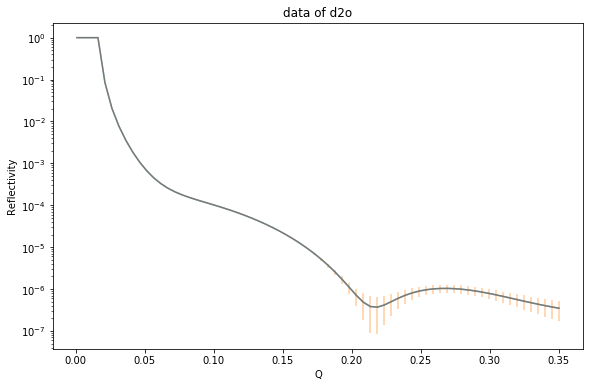

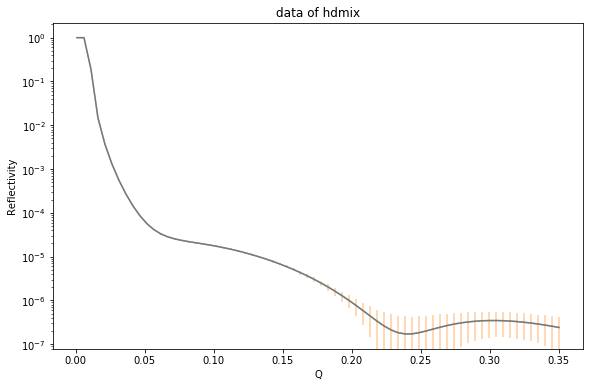

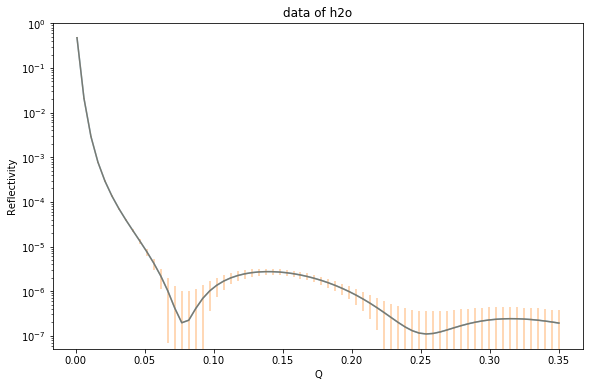

In [6]:
plt.figure(figI)
figI+=1
plt.plot(q,R_d2o)
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.title("data of d2o")
plt.yscale('log')
plt.errorbar(q,R_d2o,sim_dR_d2o,alpha=0.4)

plt.figure(figI)
figI+=1
plt.plot(q,R_hdmix)
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.title("data of hdmix")
plt.yscale('log')
plt.errorbar(q,R_hdmix,sim_dR_hdmix,alpha=0.4)

plt.figure(figI)
figI+=1
plt.plot(q,R_h2o)
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.title("data of h2o")
plt.yscale('log')
plt.errorbar(q,R_h2o,sim_dR_h2o,alpha=0.4)

In [7]:
air = SLD(0 + 0j)
d2o = SLD(6.36 + 0j)
h2o = SLD(-0.56 + 0j)
hdmix = SLD(2.07 + 0j)

d2o.real.setp(vary=True, bounds=(6.1, 6.6))
d2o.real.name='d2o SLD'

apm = Parameter(56, 'area per molecule', vary=True, bounds=(52, 65))
b_heads = Parameter(6.01e-4, 'b_heads')
b_tails = Parameter(-2.92e-4, 'b_tails')
v_heads = Parameter(319, 'v_heads')
v_tails = Parameter(782, 'v_tails')
inner_head_thickness = Parameter(9, 'inner_head_thickness', vary=True, bounds=(4, 11))
outer_head_thickness = Parameter(9, 'outer_head_thickness', vary=True, bounds=(4, 11))
tail_thickness = Parameter(14, 'tail_thickness', vary=True, bounds=(10, 17))

inner_leaflet = LipidLeaflet(apm,
                             b_heads, v_heads, inner_head_thickness,
                             b_tails, v_tails, tail_thickness,
                             3, 3)
outer_leaflet = LipidLeaflet(apm,
                             b_heads, v_heads, outer_head_thickness,
                             b_tails, v_tails, tail_thickness,
                             3, 0, reverse_monolayer=True)

solv_roughness = Parameter(3, 'bilayer/solvent roughness')
solv_roughness.setp(vary=True, bounds=(0, 5))

s_d2o = air | inner_leaflet | outer_leaflet | d2o(0, solv_roughness)
s_hdmix = air | inner_leaflet | outer_leaflet | hdmix(0, solv_roughness)
s_h2o = air | inner_leaflet | outer_leaflet | h2o(0, solv_roughness)

In [8]:
model_d2o = ReflectModel(s_d2o,bkg=0,dq=5.)
model_hdmix = ReflectModel(s_hdmix,bkg=0,dq=5.)
model_h2o = ReflectModel(s_h2o,bkg=0,dq=5.)

objective_d2o = Objective(model_d2o, data_d2o,
                  transform=Transform('logY'),logp_extra=logp_extra)
objective_hdmix = Objective(model_hdmix, data_hdmix,
                  transform=Transform('logY'),logp_extra=logp_extra)
objective_h2o = Objective(model_h2o, data_h2o,
                  transform=Transform('logY'),logp_extra=logp_extra)

global_objective = GlobalObjective([objective_d2o, objective_hdmix, objective_h2o])

In [9]:
# objective = gO(data, 1) #06:09
fitter = CFitter(global_objective)
DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
DNSampler.run_nested(dlogz_init=0.01)
res1 = DNSampler.results

32329it [21:42, 24.82it/s, batch: 10 | bound: 162 | nc: 1 | ncall: 144379 | eff(%): 22.392 | loglstar: 356.589 < 365.279 < 363.893 | logz: 343.934 +/-  0.262 | stop:  0.882]           


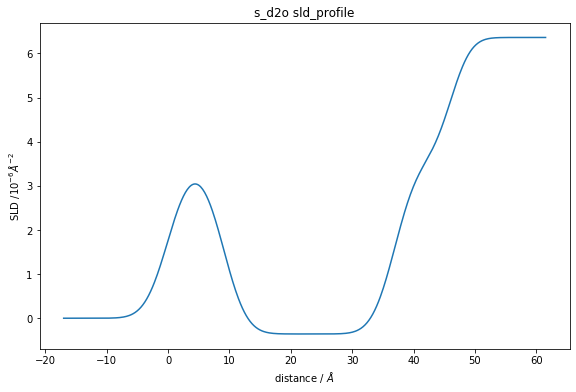

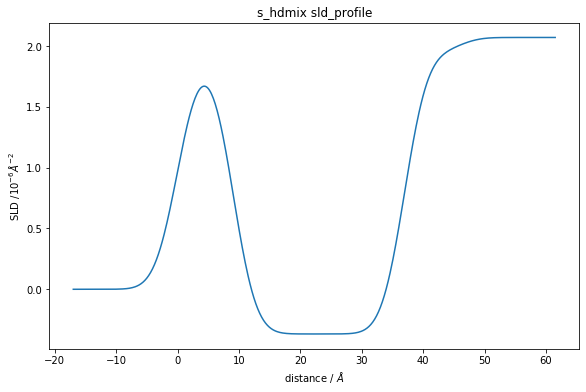

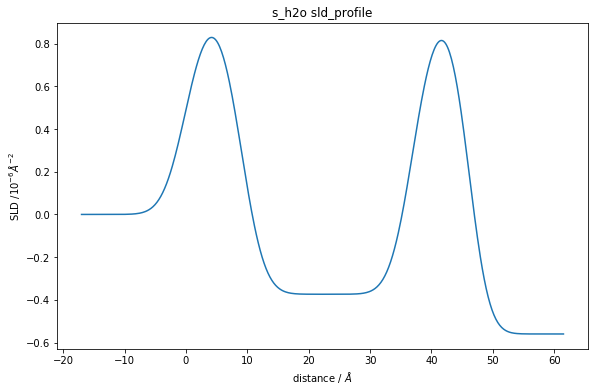

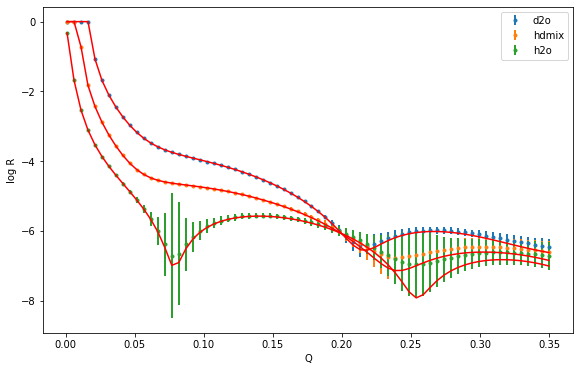

In [10]:
plt.rcParams['figure.figsize'] = [9.5, 6]
plt.figure(figI)
figI+=1
plt.plot(*s_d2o.sld_profile())
plt.title("s_d2o sld_profile")
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');

plt.rcParams['figure.figsize'] = [9.5, 6]
plt.figure(figI)
figI+=1
plt.plot(*s_hdmix.sld_profile())
plt.title("s_hdmix sld_profile")
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');

plt.rcParams['figure.figsize'] = [9.5, 6]
plt.figure(figI)
figI+=1
plt.plot(*s_h2o.sld_profile())
plt.title("s_h2o sld_profile")
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');


# plt.figure(figI)
# figI+=1
# plt.plot(q,R_d2o)
# plt.xlabel('Q')
# plt.ylabel('Reflectivity')
# plt.title("data of d2o")
# plt.yscale('log')
# plt.errorbar(q,R_d2o,sim_dR_d2o,alpha=0.4)

# plt.figure(figI)
# figI+=1
# plt.plot(q,R_hdmix)
# plt.xlabel('Q')
# plt.ylabel('Reflectivity')
# plt.title("data of hdmix")
# plt.yscale('log')
# plt.errorbar(q,R_hdmix,sim_dR_hdmix,alpha=0.4)

# plt.figure(figI)
# figI+=1
# plt.plot(q,R_h2o)
# plt.xlabel('Q')
# plt.ylabel('Reflectivity')
# plt.title("data of h2o")
# plt.yscale('log')
# plt.errorbar(q,R_h2o,sim_dR_h2o,alpha=0.4)


global_objective.plot()
# plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('log R')
plt.legend();

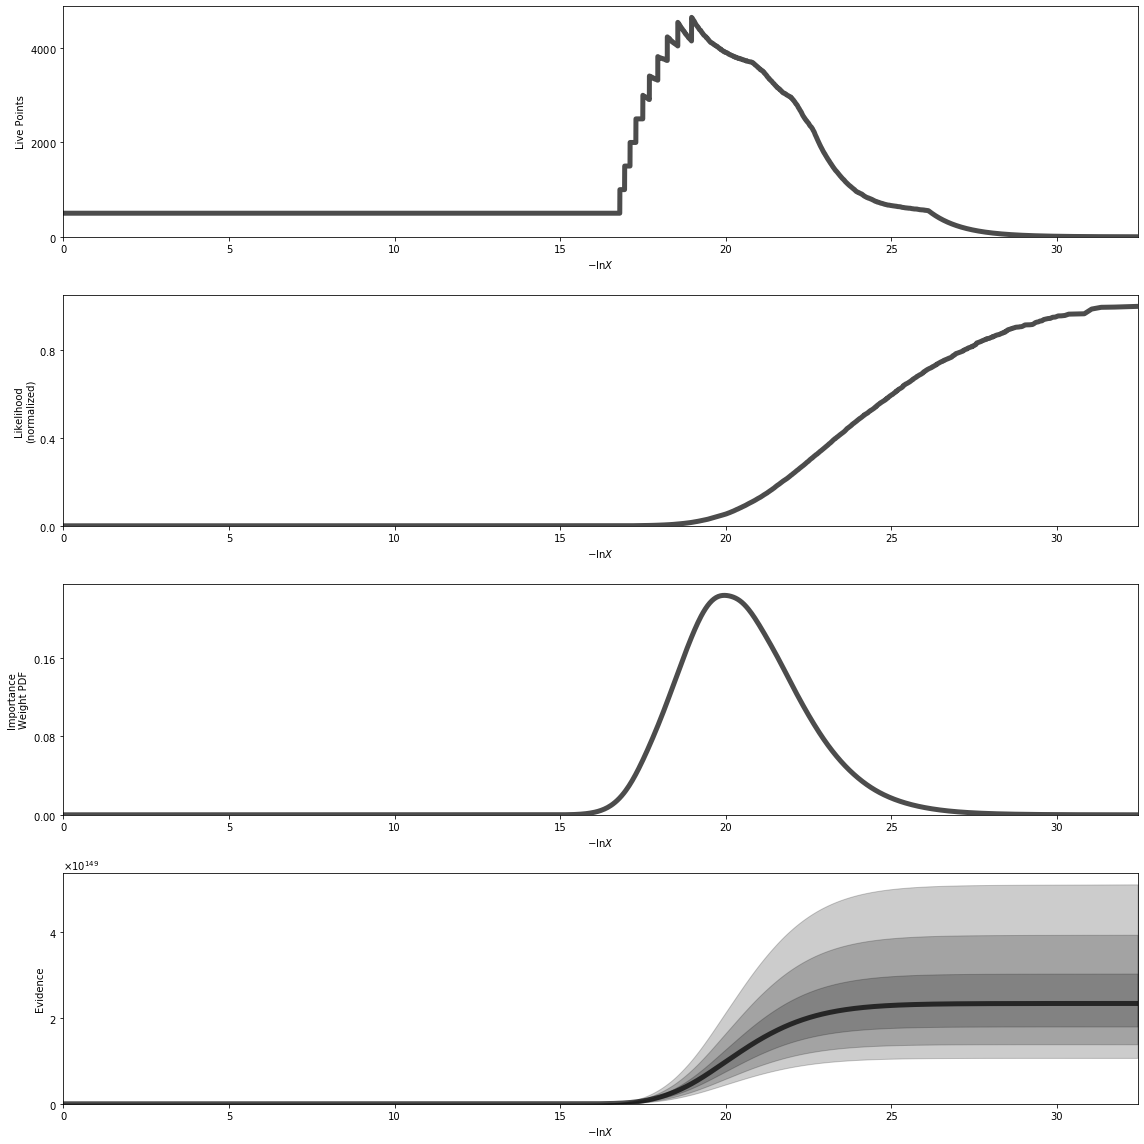

In [11]:
# span = [(0,5000),(0,1.5),(0,0.4),(10**0,10**10)] #,span=span
fig, axes = dyplot.runplot(res1, color='black', mark_final_live=False,
                           logplot=False)
fig.tight_layout()

9
len 32329 space size 29
logz max:  343.9363683553877 ,min:  -96455.51964924758
z max:  2.3424315160094455e+149 ,min:  0.0
10


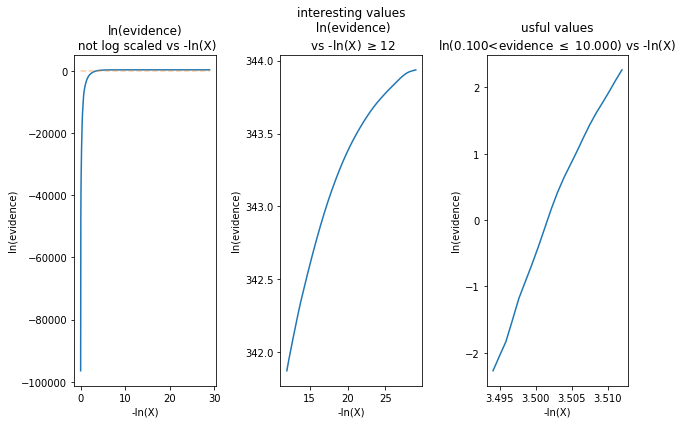

In [12]:
figI = aPlotter(res1, 12, 29, figI)

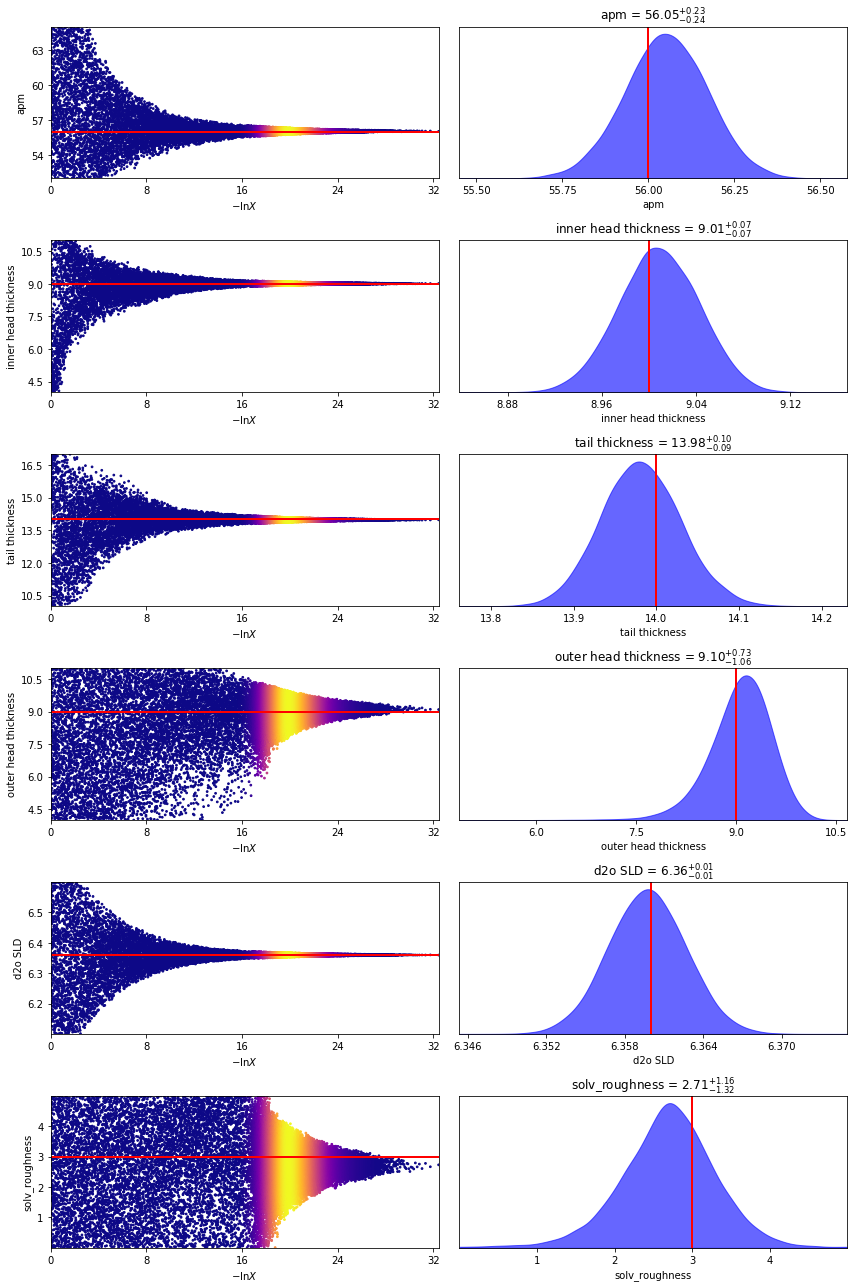

In [13]:
labels = ["apm", "inner head thickness", "tail thickness", "outer head thickness", "d2o SLD", "solv_roughness"]
true_values = [56, 9, 14, 9, 6.36, 3]
fig, axes = dyplot.traceplot(res1, labels = labels, truths=true_values,
                             show_titles=True, trace_cmap='plasma',
                             quantiles=None)
fig.tight_layout()